# Chaper 8 - Intrinsic Curiosity Module
#### Deep Reinforcement Learning *in Action*

##### Listing 8.1

In [1]:
import gym
# action들을 조합해서 action space 크기를 줄인다고 한다 
from nes_py.wrappers import JoypadSpace #A
import gym_super_mario_bros
# 단순한 action, 복잡한 action을 선택할 수 있다 
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT #B


In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) #C
done = True
for step in range(2500): #D
    if done:
        state = env.reset()
    # 무작위로 해본다 
    state, reward, done, info = env.step(env.action_space.sample())
    # print(info)
    env.render()

# 밑에서 plt.show()가 안나오는 문제를 위해 나중에 close()
# env.close()

c:\Users\tkddu\anaconda3\envs\RL\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


In [3]:
# info 정보
# int coins: 수집한 동전 개수
# bool flag_get: 깃발이나 도끼에 도달
# int life: 남은 생명(3,2,1)
# int score: 누적 게임 점수
# int stage: 현재 스테이지(1,2,3,4)
# str status: 마리오의 상태('small', 'tall', 'fireball')
# int time: 남은 게임 시간
# int world: 현재 세계(1,2,3,...,8)
# int x_pos: 현재 스테이지에서 마리오의 x 좌표

##### Listing 8.2

In [4]:
import matplotlib.pyplot as plt
from skimage.transform import resize #A  이미지 크기를 줄이는 함수 
import numpy as np

def downscale_obs(obs, new_size=(42,42), to_gray=True):
    # RGB 중 가장 큰 값을 고르면 대비가 좋은 회색조를 얻을 수 있음 
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) #B
    else:
        return resize(obs, new_size, anti_aliasing=True)

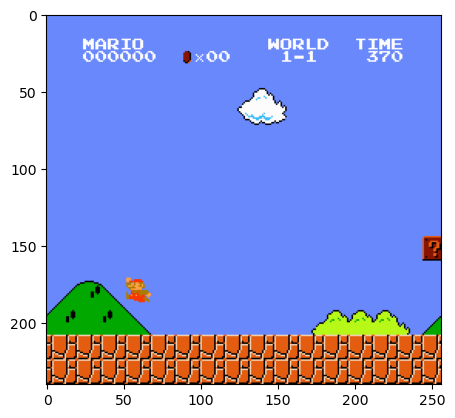

In [5]:
plt.imshow(env.render("rgb_array"))


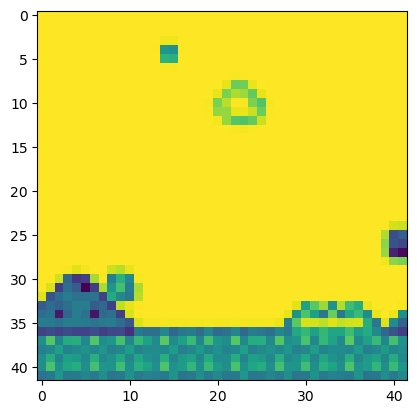

In [6]:

plt.imshow(downscale_obs(env.render("rgb_array")))
env.close()
# 상당히 흐릿하지만 필요한 정보는 충분하다 

##### Listing 8.3

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state): #A
    # unsqueeze(): 1 짜리 차원을 dim에 추가한다 ex) (42,42) -> (1,42,42)
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)


def prepare_multi_state(state1, state2): #B  새로운 state를 반영 
    state1 = state1.clone()  # 인자로 주어진 state1에 영향이 가지 않게 하기위해?
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1


def prepare_initial_state(state,N=3): #C
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N,1,1))
    # return되는 tensor는 [state_, state_, state_] 와 같다 
    return tmp.unsqueeze(dim=0)

In [8]:
# repeat 함수 확인을 위해 
a = torch.from_numpy(np.array([
    [i for i in range(42)] for j in range(42)
]))
a.repeat((3,1,1))

tensor([[[ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         ...,
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41]],

        [[ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         ...,
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41]],

        [[ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         ...,
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41],
         [ 0,  1,  2,  ..., 39, 40, 41]]], dtype=torch.int32)

##### Listing 8.4

In [9]:
# epsilon-greedy와 softmax sampling을 둘 다 혼합 
def policy(qvalues, eps=None): #A
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0,high=7,size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        # softmax 를 통해 확률적으로 하나 뽑기 
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #B

##### Listing 8.5

In [10]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N #A
        self.batch_size = batch_size #B
        self.memory = [] 
        self.counter = 0
        
    def add_memory(self, state1, action, reward, state2):
        self.counter +=1 
        # 500개 마다 섞어주면서 배치가 더 무작위로 추출되게 함 (의미가 있을까?)
        if self.counter % 500 == 0: #C
            self.shuffle_memory()
            
        if len(self.memory) < self.N: #D
            self.memory.append( (state1, action, reward, state2) )
        else:  # 꽉찼으면 랜덤한 위치를 새로운 경험으로 대체 
            rand_index = np.random.randint(0,self.N-1)
            self.memory[rand_index] = (state1, action, reward, state2)
    
    def shuffle_memory(self): #E
        shuffle(self.memory)
        

    def get_batch(self): #F
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size

        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        #G 랜덤한 위치로 배치를 만들어줌 
        ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False)
        batch = [self.memory[i] for i in ind] #batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

##### Listing 8.6

In [11]:
class Phi(nn.Module): #A 부호기, input의 크기를 줄인다. 
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))  # (1, 32, 21, 21)
        y = F.elu(self.conv2(y))  # (1, 32, 11, 11)
        y = F.elu(self.conv3(y))  # (1, 32, 6, 6)
        y = F.elu(self.conv4(y)) #size [1, 32, 3, 3] batch, channels, 3 x 3
        y = y.flatten(start_dim=1) #size N, 288 => 32*3*3
        return y

class Gnet(nn.Module): #B  (state, next_state) -> action 
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576,256)  # (2*288) -> 256
        self.linear2 = nn.Linear(256,12) 

    def forward(self, state1,state2):
        x = torch.cat( (state1, state2) ,dim=1)  # 부호화된 state들을 붙임 
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y,dim=1)
        return y

class Fnet(nn.Module): #C (state, action) -> next_state
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300,256)  # (288+12) -> 256
        self.linear2 = nn.Linear(256,288)

    def forward(self,state,action):
        action_ = torch.zeros(action.shape[0],12) #D  action.shape[0]: batch size 
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()  # indices[i][j]: i번째 배치의 action은 j 
        action_[indices] = 1.  # indices를 인덱스로 이용 
        x = torch.cat( (state,action_) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

##### Listing 8.7

In [12]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        #in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,12)
        
    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y) #size N, 12
        return y

##### Listing 8.8

In [13]:
# LOSS = lambda*Qloss + (1-beta)*Floss + beta*Gloss 
# episode가 max_episode_len에 도달할 때까지 min_progress를 넘기지 못하면 환경을 초기화
# 한 장애물을 넘기지 못하고 영원히 반복하면서 시간을 낭비하는걸 해결하기 위해 
# 한 주기에서 마리오는 action_repeat만큼 반복함(빨리 학습하기 위해) 
# 하나의 상태는 frames_per_state 수 만큼의 프레임을 갖는다. 
# eta: 내재적 보상을 얼마나 사용할 것인지. 클수록 더 적게 사용 
params = {
    'batch_size':128,
    'beta':0.2,
    'lambda':0.1,
    'eta': 0.5,
    'gamma':0.9,
    'max_episode_len':150,
    'min_progress':15,
    'action_repeats':6,
    'frames_per_state':3
}


replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
'''
nn.MSELoss() 의 reduction 매개 변수는 손실을 계산하는 방법을 지정
default='mean' -> 모든 손실의 평균
sum -> 모든 요소의 합
none -> 각 요소의 손실
'''
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) #A  한번에 훈련 
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.0001, params=all_model_params)

##### Listing 8.9

In [14]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]  # loss 정규화? 
    loss = loss_ + params['lambda'] * q_loss
    return loss

def reset_env():
    """
    Reset the environment and return a new initial state
    """
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
    return state1

##### Listing 8.10

In [15]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1) #A
    state2_hat = encoder(state2)
    # 부호화된 상태로 순방향 모형 실행 (역전파에서 떼어냄)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) #B
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, \
                        state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    # 역방향 모형은 동작에 관한 softmax 분포 리턴 
    pred_action = inverse_model(state1_hat, state2_hat) #C
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, \
                                        action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

In [16]:
# reduction에 따른 두 방식의 차이 

fl = nn.MSELoss(reduction='none')
tt = torch.tensor([[1,2,3],[2,3,4]], dtype=torch.float)
tt2 = torch.tensor([[4,5,6],[2,3,4]], dtype=torch.float)
print(fl(tt,tt2))
# [[9+9+9],[0+0+0]]
print(fl(tt,tt2).sum(dim=1).unsqueeze(dim=1))  # 행마다 손실 측정 가능 

fl2 = nn.MSELoss(reduction='mean')
print(fl2(tt,tt2))  # (9+9+9+0+0+0)/6 = 4.5

tensor([[9., 9., 9.],
        [0., 0., 0.]])
tensor([[27.],
        [ 0.]])
tensor(4.5000)


##### Listing 8.11

In [17]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch() 
    action_batch = action_batch.view(action_batch.shape[0],1) #A
    reward_batch = reward_batch.view(reward_batch.shape[0],1)
    
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #B

    i_reward = (1. / params['eta']) * forward_pred_err #C
    reward = i_reward.detach() #D
    if use_extrinsic: #E  외재적 보상도 사용한다면
        reward += reward_batch 

    qvals = Qmodel(state2_batch) #F
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()

    # action들을 one-hot encoding
    indices = torch.stack( (torch.arange(action_batch.shape[0]), \
    action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

##### Listing 8.12

In [19]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) 

epochs = 5000
env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))
eps=0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000  # 1000번 이후론 epsilon-greedy 
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = env.env.env._x_position #A  스테이지 진척도 계산을 위해 마리오의 마지막 x위치를 가져옴 
ep_lengths = []
use_extrinsic = True

for i in range(epochs):
    # if i%50==0: print("epoch:",i)
    opt.zero_grad()  # Adam, 관련 코드는 위에 있음 
    episode_length += 1
    q_val_pred = Qmodel(state1) #B

    # epsilon greedy와 softmax 혼합 policy
    if i > switch_to_eps_greedy: #C
        action = int(policy(q_val_pred,eps))
    else:
        action = int(policy(q_val_pred))

    # action_repeats만큼 액션 반복     
    for j in range(params['action_repeats']): #D
        state2, e_reward_, done, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))

    state2 = torch.stack(list(state_deque),dim=1) #E
    replay.add_memory(state1, action, e_reward, state2) #F
    e_reward = 0

    if episode_length > params['max_episode_len']: #G
        # 스테이지를 충분히 나아가지 못했다면 초기화 
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']

    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = env.env.env._x_position
        episode_length = 0
    else:
        state1 = state2

    # 아직 replay memory가 다 찰 때까지 그냥 게임 진행 
    if len(replay.memory) < params['batch_size']:
        continue

    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=use_extrinsic) #H
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) #I
    
    # loss 값들을 저장해두자
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(),\
        inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    if i%50==0: print("epoches:",i,", losses:",losses[-1])
    loss.backward()
    opt.step()

C:\Users\tkddu\AppData\Local\Temp\ipykernel_22792\2379933512.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #B


epoches: 150 , losses: (tensor(11274.8359, grad_fn=<MeanBackward0>), tensor(13.8495, grad_fn=<MeanBackward0>), tensor(24609.6191, grad_fn=<MeanBackward0>))
epoches: 200 , losses: (tensor(10603.8672, grad_fn=<MeanBackward0>), tensor(0.4389, grad_fn=<MeanBackward0>), tensor(24452.5078, grad_fn=<MeanBackward0>))
epoches: 250 , losses: (tensor(9637.8887, grad_fn=<MeanBackward0>), tensor(0.2437, grad_fn=<MeanBackward0>), tensor(24719.2129, grad_fn=<MeanBackward0>))
epoches: 300 , losses: (tensor(8990.7637, grad_fn=<MeanBackward0>), tensor(0.0928, grad_fn=<MeanBackward0>), tensor(24639.9766, grad_fn=<MeanBackward0>))
epoches: 350 , losses: (tensor(8863.8213, grad_fn=<MeanBackward0>), tensor(0.0666, grad_fn=<MeanBackward0>), tensor(24664.1758, grad_fn=<MeanBackward0>))
epoches: 400 , losses: (tensor(9385.8145, grad_fn=<MeanBackward0>), tensor(0.0525, grad_fn=<MeanBackward0>), tensor(24692.2324, grad_fn=<MeanBackward0>))
epoches: 450 , losses: (tensor(8985.4639, grad_fn=<MeanBackward0>), tenso

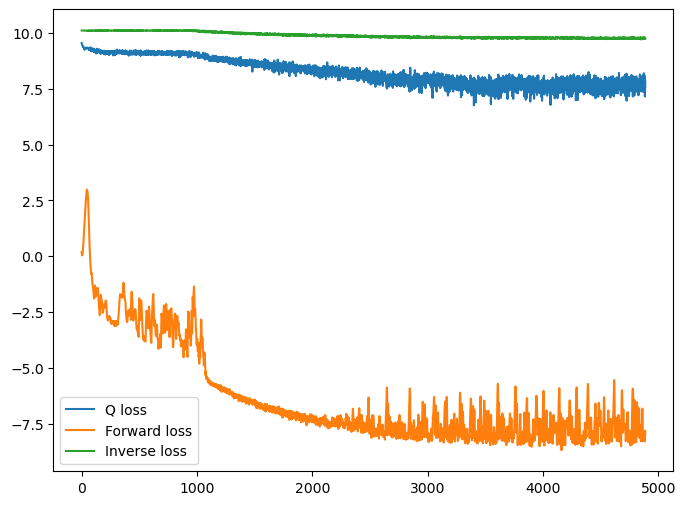

In [20]:
with torch.no_grad():
    losses_ = np.array(losses)
plt.figure(figsize=(8,6))
plt.plot(np.log(losses_[:,0]),label='Q loss')
plt.plot(np.log(losses_[:,1]),label='Forward loss')
plt.plot(np.log(losses_[:,2]),label='Inverse loss')
plt.legend()
plt.show()

##### Test Trained Agent

In [30]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) #C
done = True
eps = 0.2
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(5000):
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render('rgb_array'))
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred,eps))
    state2, reward, done, info = env.step(action)
    # print(info)
    state2 = prepare_multi_state(state1,state2)
    state1=state2
    env.render()

In [31]:
env.close()

In [29]:
# to save model, execute this
torch.save(Qmodel.state_dict(), 'Qmodel.pt')


In [31]:
# to load model, execute this
Qmodel = Qnetwork()
Qmodel.load_state_dict(torch.load('Qmodel.pt'))


<All keys matched successfully>